# Policy Gradients
In the previous lessons we were approximating the action value function using function approximator in order to find the best policy by acting greedily with respect to this action value function
Isn't that a bit far fetched? Isn't there an easier way to find the best policy?
The goal here is to parametrise a policy and to find the best set of parameters to have a policy that optimizes the cumulated rewards:
$$
\pi_{\theta}(s)= \mathbb P [a|s,\theta]
$$

To find the optimal set of parameters we have to maximise the expectancy of the cumulated rewards, the policy gradient is the following quantity:
$$
\nabla_{\theta}J(\theta) = \mathbb E _{\pi_{\theta}} [\nabla_{\theta}\text{log}\pi_{\theta}(s,a)Q^{\pi_{\theta}}(s,a)]
$$
The reinforce algorithm uses the return $v_t$ as an unbiased sample of $Q^{\pi_{\theta}}(s,a)$

What the lesson does not say is that implementing this algorithm won't always work, for instance if the environement always gives positive rewards: all the behaviors having positive reward will be reinforced, therefore it is common use to normalize the returns so as to favor actions that allow receiving a reward above average and discourage action that received rewards under average.

I implemented the reinforce algorithm in a "handmade" environement: the agent is on a 2D slippery table (it has a momentum) and can only be pushed up, down, right or left. Yet it receives a reward by reaching the goal that has a random position. The state of the environement is the relative position of the agent and the arrival and the speed of the agent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple

class ReplayMemory(object):
    """
    Memory that will be used to replay the actions previously encountered
    allows to "remember" the past states
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


#transitions that need to be stored  we just need the tuples (state,action,reward) not the next states and actions
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class Environement(object):
    """
    The environement here is a table where a ball has to reach a hole
    The destination and the position of the ball are initialized randomly
    """
    def __init__(self,dim,min_value,max_value,drag):
        #dimension of te table
        self.dim = dim
        # max dimensions of the table
        self.min_value = min_value
        self.max_value = max_value
        
        #defining action and state space
        self.action_dim = self.dim*2
        self.state_dim = self.dim*2
        self.drag = drag
    
    def reset(self):
        """
        function to restart another episode
        """
        self.destination = torch.rand(self.dim)*(self.max_value-self.min_value)+self.min_value
        self.position = torch.rand(self.dim)*(self.max_value-self.min_value)+self.min_value
        self.momentum = torch.zeros(self.dim)

    @property
    def state(self):
        """
        State that would be given to the agent: relative position + speed
        """
        return torch.cat([(self.position-self.destination),self.momentum],dim=0)
    

    def step(self,action):
        """
        Main function for executing a timestep
        """
        with torch.no_grad():
            #action dimension
            dim = action //2
            #action way
            toward = (action%2)*2 -1
            
            #decaying momentum
            self.momentum *= self.drag
            #adding action to momentum
            self.momentum[dim] += toward*0.02
            #moving 
            self.position = self.position+self.momentum
            #if hitting a wall nullify speed and clamp position
            for i in range(self.position.shape[0]):
                if self.position[i]>self.max_value or self.position[i]<self.min_value:
                    self.position[i]=torch.clamp(self.position[i],self.min_value,self.max_value)
                    self.momentum[i]=0
            
            state = self.state
            #checking if we arrived
            distance = torch.sqrt(torch.sum((self.position-self.destination)**2))
            if distance.item() < 0.01:
                reward = 1
                done=True
            else:
                reward = -0.01
                done = False
            return state,reward,done

#policy learner general class 
class ReinforceAgent(object):
    def __init__(self,temperature, temperature_decay):
        self._temperature = temperature
        self.temperature_decay = temperature_decay
        self.time = 0

    #for selecting random actions
    @property
    def temperature(self):
        return max(self._temperature*self.temperature_decay**self.time,1)
    
    @temperature.setter
    def epsilon(self,value):
        self._temperature = value
        self.time=0

    def decay(self):
        self.time +=1

    # this one is sampling action the the policy
    def select_action(self,state):
        probs = self.probs_from_state(state)
        probs = np.array([round(prob.item(),2) for prob in probs])
        probs = probs/ np.sum(probs)

        return np.random.choice(range(probs.shape[0]),p=probs)

    def probs_from_state(self,state):
        raise NotImplementedError("The process function has to be implemented")



class AgentReinforceTorch(ReinforceAgent):
    """
    Policy agent that uses reinforce
    """
    def __init__(self,state_dim,action_dim,temperature, temperature_decay):
        ReinforceAgent.__init__(self,temperature, temperature_decay)
        #module to evaluate the probabilities
        self.decision_module = nn.Sequential(nn.Linear(state_dim,50),nn.ReLU(),nn.Linear(50,action_dim))

    #smooth the probabilities with temparature (not needed here)
    def probs_from_state(self,state):
        with torch.no_grad():
            return F.softmax(self.decision_module(state)/self.temperature)

    def gradient_probits(self,state):
        return F.softmax(self.decision_module(state))

    #function to update the network following the reinforce algorithm
    def update_network(self,memory,optimizer):
        #taking alkl episode
        transitions = memory.memory
        #batching
        batch = Transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        #negative log probability multiplied with the reward and then averaged
        loss= torch.mean(F.cross_entropy(self.decision_module(state_batch),action_batch,reduction='none')*reward_batch)
        #nullify gradients
        optimizer.zero_grad()
        #backward
        loss.backward()
        #optimization step
        optimizer.step()


In [2]:
#function running one episode for the plots
def plot_trajectory(env,agent):
    plt.figure()
    env.reset()
    state = env.state
    done = False
    t=0
    history = []
    while not done:
        action = agent.select_action(state)
        new_state, reward, done = env.step(action)
        history.append((state.numpy(),action,reward))
        state = new_state
    history.append((state.numpy(),0,0))
    print(len(history))
    print(state)
    print(env.destination)
    state,action,reward = zip(*history)
    x,y,_,_,=zip(*state)
    plt.plot(x,y)
    plt.scatter([0],[0],c='r')
    plt.show()


In [4]:
def run():
    #initialize environement
    dim = 2
    min_value = -0.3
    max_value = 0.3
    drag = 0.9
    gamma = 0.99
    env = Environement(dim,min_value,max_value,drag)

    #initialise temparature
    temperature = 1
    temperature_decay = 0.97

    agent = AgentReinforceTorch(env.state_dim,env.action_dim,temperature,temperature_decay)

    # define the optimizer
    learning_rate = 0.005
    optimizer = optim.Adam(agent.decision_module.parameters(),lr=learning_rate)

    # Building memory
    capacity = 200000
    batch_size=500
    memory = ReplayMemory(capacity)

    #display one episode for the very first agent
    plot_trajectory(env,agent)

    nb_iterations=2000

    lens=[]
    #iterate
    for iteration in range(nb_iterations):
        print("iter",iteration)
        env.reset()
        state = env.state
        done = False
        t=0
        history = []
        
        while not done:
            action = agent.select_action(state)
            new_state, reward, done = env.step(action)
            history.append((state,action,reward))
            state = new_state
            t+=1
            #exit episode if it lasts too long
            if t> 1600:
                break

        #discounting and normalizing values
        values=[]
        #discount and sum
        for i in range(len(history)):
            values.append(sum([x[2]*gamma**t for t,x in enumerate(history[i:])]))
        values = np.array(values)
        #normalize
        values = (values-np.mean(values))/(np.std(values)+0.001)
        #adding to memory
        for i in range(len(history)):
            memory.push(history[i][0].view(1,-1),torch.tensor([history[i][1]]).long(),torch.tensor([values[i]]).float())
        agent.update_network(memory,optimizer)
        #empty memory
        memory.memory=[]
        memory.position=0

        #plots and prints
        lens.append(t)
        print("length:",len(history))
        print("________")


        
    plt.plot(lens)
    plt.xlabel("Episode")
    plt.ylabel("Episode length")
    plot_trajectory(env,agent)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


8920
tensor([-0.0072, -0.0010,  0.0180, -0.0040])
tensor([-0.2548, -0.2631])


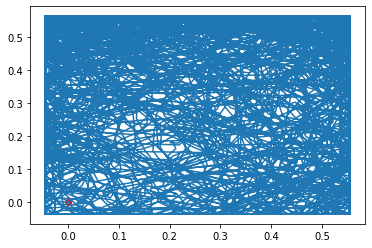

iter 0
length: 580
________
iter 1
length: 217
________
iter 2
length: 49
________
iter 3
length: 1601
________
iter 4
length: 1336
________
iter 5
length: 201
________
iter 6
length: 1601
________
iter 7
length: 1601
________
iter 8
length: 1601
________
iter 9
length: 1601
________
iter 10
length: 1601
________
iter 11
length: 454
________
iter 12
length: 290
________
iter 13
length: 1601
________
iter 14
length: 1312
________
iter 15
length: 883
________
iter 16
length: 940
________
iter 17
length: 87
________
iter 18
length: 511
________
iter 19
length: 595
________
iter 20
length: 1601
________
iter 21
length: 16
________
iter 22
length: 1601
________
iter 23
length: 1601
________
iter 24
length: 1601
________
iter 25
length: 1601
________
iter 26
length: 1601
________
iter 27
length: 1601
________
iter 28
length: 1344
________
iter 29
length: 1601
________
iter 30
length: 143
________
iter 31
length: 1601
________
iter 32
length: 1601
________
iter 33
length: 1601
________
iter 3

length: 1601
________
iter 272
length: 1601
________
iter 273
length: 1601
________
iter 274
length: 225
________
iter 275
length: 194
________
iter 276
length: 484
________
iter 277
length: 1601
________
iter 278
length: 130
________
iter 279
length: 1601
________
iter 280
length: 1601
________
iter 281
length: 1601
________
iter 282
length: 1601
________
iter 283
length: 1601
________
iter 284
length: 1601
________
iter 285
length: 1601
________
iter 286
length: 1601
________
iter 287
length: 1601
________
iter 288
length: 651
________
iter 289
length: 1601
________
iter 290
length: 314
________
iter 291
length: 1601
________
iter 292
length: 186
________
iter 293
length: 1601
________
iter 294
length: 1601
________
iter 295
length: 98
________
iter 296
length: 1601
________
iter 297
length: 1601
________
iter 298
length: 1095
________
iter 299
length: 699
________
iter 300
length: 1436
________
iter 301
length: 873
________
iter 302
length: 265
________
iter 303
length: 1601
_______

length: 224
________
iter 543
length: 1434
________
iter 544
length: 814
________
iter 545
length: 70
________
iter 546
length: 156
________
iter 547
length: 1382
________
iter 548
length: 811
________
iter 549
length: 801
________
iter 550
length: 1292
________
iter 551
length: 441
________
iter 552
length: 179
________
iter 553
length: 174
________
iter 554
length: 1508
________
iter 555
length: 349
________
iter 556
length: 172
________
iter 557
length: 23
________
iter 558
length: 41
________
iter 559
length: 1601
________
iter 560
length: 237
________
iter 561
length: 73
________
iter 562
length: 219
________
iter 563
length: 362
________
iter 564
length: 1175
________
iter 565
length: 271
________
iter 566
length: 240
________
iter 567
length: 30
________
iter 568
length: 76
________
iter 569
length: 764
________
iter 570
length: 1070
________
iter 571
length: 1601
________
iter 572
length: 1425
________
iter 573
length: 840
________
iter 574
length: 197
________
iter 575
length:

length: 355
________
iter 817
length: 210
________
iter 818
length: 307
________
iter 819
length: 145
________
iter 820
length: 87
________
iter 821
length: 281
________
iter 822
length: 574
________
iter 823
length: 182
________
iter 824
length: 25
________
iter 825
length: 801
________
iter 826
length: 380
________
iter 827
length: 576
________
iter 828
length: 434
________
iter 829
length: 532
________
iter 830
length: 354
________
iter 831
length: 175
________
iter 832
length: 298
________
iter 833
length: 43
________
iter 834
length: 401
________
iter 835
length: 196
________
iter 836
length: 84
________
iter 837
length: 667
________
iter 838
length: 3
________
iter 839
length: 1601
________
iter 840
length: 236
________
iter 841
length: 441
________
iter 842
length: 734
________
iter 843
length: 167
________
iter 844
length: 80
________
iter 845
length: 23
________
iter 846
length: 26
________
iter 847
length: 101
________
iter 848
length: 8
________
iter 849
length: 183
________

length: 120
________
iter 1093
length: 112
________
iter 1094
length: 75
________
iter 1095
length: 24
________
iter 1096
length: 46
________
iter 1097
length: 39
________
iter 1098
length: 11
________
iter 1099
length: 15
________
iter 1100
length: 349
________
iter 1101
length: 56
________
iter 1102
length: 55
________
iter 1103
length: 96
________
iter 1104
length: 26
________
iter 1105
length: 140
________
iter 1106
length: 11
________
iter 1107
length: 460
________
iter 1108
length: 17
________
iter 1109
length: 14
________
iter 1110
length: 164
________
iter 1111
length: 19
________
iter 1112
length: 86
________
iter 1113
length: 54
________
iter 1114
length: 67
________
iter 1115
length: 91
________
iter 1116
length: 96
________
iter 1117
length: 31
________
iter 1118
length: 179
________
iter 1119
length: 280
________
iter 1120
length: 131
________
iter 1121
length: 14
________
iter 1122
length: 44
________
iter 1123
length: 170
________
iter 1124
length: 233
________
iter 1125

length: 235
________
iter 1364
length: 397
________
iter 1365
length: 143
________
iter 1366
length: 149
________
iter 1367
length: 27
________
iter 1368
length: 21
________
iter 1369
length: 126
________
iter 1370
length: 11
________
iter 1371
length: 21
________
iter 1372
length: 230
________
iter 1373
length: 145
________
iter 1374
length: 68
________
iter 1375
length: 30
________
iter 1376
length: 39
________
iter 1377
length: 95
________
iter 1378
length: 192
________
iter 1379
length: 82
________
iter 1380
length: 37
________
iter 1381
length: 162
________
iter 1382
length: 85
________
iter 1383
length: 184
________
iter 1384
length: 83
________
iter 1385
length: 101
________
iter 1386
length: 62
________
iter 1387
length: 67
________
iter 1388
length: 10
________
iter 1389
length: 16
________
iter 1390
length: 14
________
iter 1391
length: 5
________
iter 1392
length: 162
________
iter 1393
length: 333
________
iter 1394
length: 22
________
iter 1395
length: 52
________
iter 139

length: 103
________
iter 1635
length: 56
________
iter 1636
length: 70
________
iter 1637
length: 60
________
iter 1638
length: 110
________
iter 1639
length: 93
________
iter 1640
length: 16
________
iter 1641
length: 94
________
iter 1642
length: 66
________
iter 1643
length: 116
________
iter 1644
length: 11
________
iter 1645
length: 170
________
iter 1646
length: 101
________
iter 1647
length: 163
________
iter 1648
length: 14
________
iter 1649
length: 21
________
iter 1650
length: 250
________
iter 1651
length: 84
________
iter 1652
length: 46
________
iter 1653
length: 343
________
iter 1654
length: 40
________
iter 1655
length: 14
________
iter 1656
length: 146
________
iter 1657
length: 52
________
iter 1658
length: 74
________
iter 1659
length: 44
________
iter 1660
length: 63
________
iter 1661
length: 3
________
iter 1662
length: 81
________
iter 1663
length: 19
________
iter 1664
length: 128
________
iter 1665
length: 31
________
iter 1666
length: 24
________
iter 1667
l

length: 105
________
iter 1909
length: 13
________
iter 1910
length: 79
________
iter 1911
length: 45
________
iter 1912
length: 19
________
iter 1913
length: 14
________
iter 1914
length: 54
________
iter 1915
length: 121
________
iter 1916
length: 194
________
iter 1917
length: 28
________
iter 1918
length: 226
________
iter 1919
length: 57
________
iter 1920
length: 37
________
iter 1921
length: 13
________
iter 1922
length: 34
________
iter 1923
length: 158
________
iter 1924
length: 39
________
iter 1925
length: 16
________
iter 1926
length: 115
________
iter 1927
length: 149
________
iter 1928
length: 3
________
iter 1929
length: 27
________
iter 1930
length: 26
________
iter 1931
length: 12
________
iter 1932
length: 81
________
iter 1933
length: 50
________
iter 1934
length: 71
________
iter 1935
length: 57
________
iter 1936
length: 114
________
iter 1937
length: 35
________
iter 1938
length: 144
________
iter 1939
length: 86
________
iter 1940
length: 9
________
iter 1941
len

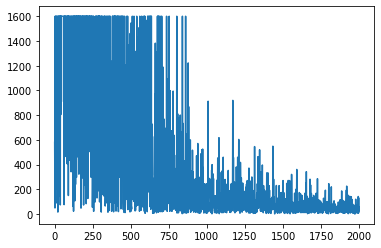

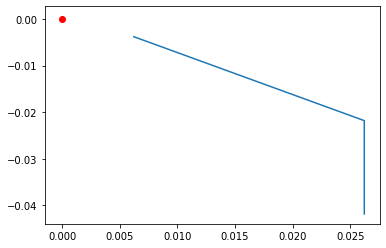

In [5]:
run()

As you see it takes a while for the algorithm to understand what is the best course of actions as the destination is quite small but evently it becomes better and better
I didn't implemented the actor-critic structure here as this already cost me some amount of time ahaha